### Instala bibliotecas e copia repositórios

In [ ]:
import torch

# Verificar se há uma GPU disponível
if torch.cuda.is_available():
    # Obter o nome da GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU disponível: {gpu_name}")
else:
    print("Nenhuma GPU disponível.")


GPU disponível: NVIDIA A100-SXM4-40GB


In [ ]:
import os
import shutil
import json
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Clona o repositório
!git clone https://github.com/lyuwenyu/RT-DETR
!git clone https://github.com/pedrozamboni/individual_urban_tree_crown_detection

Cloning into 'RT-DETR'...
remote: Enumerating objects: 990, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 990 (delta 2), reused 8 (delta 1), pack-reused 978 (from 1)
Receiving objects: 100% (990/990), 622.01 KiB | 23.04 MiB/s, done.
Resolving deltas: 100% (460/460), done.
Cloning into 'individual_urban_tree_crown_detection'...
remote: Enumerating objects: 696, done.
remote: Total 696 (delta 0), reused 0 (delta 0), pack-reused 696 (from 1)
Receiving objects: 100% (696/696), 184.86 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (677/677), done.


In [ ]:
import os
import random

##########################
## Unifica arquivos txt ##
##########################

# Caminhos de entrada e saída
base_input_path = "/content/individual_urban_tree_crown_detection/img_list"
output_base_path = "/content/RT-DETR/rtdetrv2_pytorch/dataset/img_list"

# Nomes dos arquivos que deseja combinar
file_names = ["test.txt", "train.txt", "val.txt"]

# Certifique-se de que o diretório de saída exista
os.makedirs(output_base_path, exist_ok=True)

# Conjunto para armazenar valores únicos
unique_lines = set()

# Combinar conteúdo de todos os arquivos
for file_name in file_names:
    # Percorrer os diretórios 0 a 4
    for i in range(5):  # Intervalo de 0 a 4
        file_path = os.path.join(base_input_path, str(i), file_name)
        if os.path.exists(file_path):  # Verifica se o arquivo existe
            with open(file_path, 'r') as file:
                unique_lines.update(file.readlines())

# Ordenar os valores únicos
sorted_lines = sorted(unique_lines)

# Dividir os dados em treino (70%), validação (20%) e teste (10%)
total_lines = len(sorted_lines)
train_end = int(0.7 * total_lines)
val_end = int(0.9 * total_lines)

train_lines = sorted_lines[:train_end]
val_lines = sorted_lines[train_end:val_end]
test_lines = sorted_lines[val_end:]

# Salvar os arquivos
file_paths = {
    "train.txt": train_lines,
    "val.txt": val_lines,
    "test.txt": test_lines,
}

for file_name, lines in file_paths.items():
    output_path = os.path.join(output_base_path, file_name)
    with open(output_path, 'w') as file:
        file.writelines(lines)
    print(f"Arquivo {file_name} salvo em {output_path}")


Arquivo train.txt salvo em /content/RT-DETR/rtdetrv2_pytorch/dataset/img_list/train.txt
Arquivo val.txt salvo em /content/RT-DETR/rtdetrv2_pytorch/dataset/img_list/val.txt
Arquivo test.txt salvo em /content/RT-DETR/rtdetrv2_pytorch/dataset/img_list/test.txt


### Pré-processamento

In [ ]:
#########################################
## Transfere arquivos e cria anotações ##
#########################################

# Caminhos das pastas
base_dir = 'individual_urban_tree_crown_detection'
images_dir = os.path.join(base_dir, 'rgb')
annotations_dir = os.path.join(base_dir, 'bbox_txt')
img_list_dir = "/content/RT-DETR/rtdetrv2_pytorch/dataset/img_list"

# Novos diretórios
output_dir = "/content/RT-DETR/rtdetrv2_pytorch/dataset"
output_images_dir = os.path.join(output_dir, 'imagens')
output_annotations_dir = os.path.join(output_dir, 'annotations')

# Garantir que os diretórios de saída existem
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_annotations_dir, exist_ok=True)

# Função para processar um conjunto (train, val ou test)
def process_set(set_name, verbose = True):
    # Criar diretório para as imagens do conjunto
    set_images_dir = os.path.join(output_images_dir, set_name)
    os.makedirs(set_images_dir, exist_ok=True)

    # Ler a lista de imagens
    set_list_file = os.path.join(img_list_dir, f'{set_name}.txt')
    if verbose: print(f"Processando conjunto '{set_name}'...")

    with open(set_list_file, 'r') as f:
        image_files = [line.strip() for line in f.readlines()]

    images = []
    annotations = []
    annotation_id = 1  # ID único para cada anotação
    for image_id, image_file in enumerate(image_files, 1):
        # Copiar a imagem para o diretório correspondente
        src_image_path = os.path.join(images_dir, image_file)
        dst_image_path = os.path.join(set_images_dir, image_file)
        shutil.copyfile(src_image_path, dst_image_path)
        if verbose: print(f"Copiando imagem '{image_file}': de {src_image_path} para {dst_image_path} ...")

        # Obter as dimensões da imagem
        with Image.open(src_image_path) as img:
            width, height = img.size
            if verbose: print(f"Dimensões da imagem '{image_file}': {width}x{height}")

        # Adicionar entrada para a imagem
        images.append({
            'id': image_id,
            'file_name': image_file,
            'width': width,
            'height': height
        })
        if verbose: print(f"Adicionando entrada para a imagem '{image_file}'")

        # Ler o arquivo de anotações correspondente
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        annotation_path = os.path.join(annotations_dir, annotation_file)
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                # Remover quebras de linha e espaços extras
                line = line.strip()
                if not line:
                    continue

                # Separar os valores
                parts = line.split()
                if len(parts) != 4:
                    print(f"Aviso: Formato inválido na linha '{line}' do arquivo '{annotation_path}'.")
                    continue

                # Converter para float
                try:
                    x_min, y_min, x_max, y_max = map(float, parts)
                except ValueError:
                    print(f"Aviso: Valores não numéricos na linha '{line}' do arquivo '{annotation_path}'.")
                    continue
                if verbose: print(f"Coordenadas: x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}")

                # Garantir que as coordenadas estão dentro dos limites da imagem
                x_min = max(0, min(x_min, width - 1))
                y_min = max(0, min(y_min, height - 1))
                x_max = max(0, min(x_max, width - 1))
                y_max = max(0, min(y_max, height - 1))

                if verbose: print(f"Coordenadas ajustadas: x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}")

                # Calcular largura e altura
                bbox_width = x_max - x_min
                bbox_height = y_max - y_min

                # if bbox_width <= 0 or bbox_height <= 0:
                #     print(f"Aviso: BBox com largura ou altura zero na imagem '{image_file}'.")
                #     continue

                # Adicionar anotação
                annotations.append({
                    'id': annotation_id,
                    'image_id': image_id,
                    'category_id': 0,  # ID da categoria (apenas uma classe)
                    'bbox': [x_min, y_min, bbox_width, bbox_height],
                    'area': bbox_width * bbox_height,
                    'iscrowd': 0
                })
                annotation_id += 1
        else:
            print(f"Aviso: Arquivo de anotação '{annotation_path}' não encontrado.")

    # Criar a estrutura final do JSON
    coco_format = {
        'images': images,
        'annotations': annotations,
        'categories': [
            {
                'id': 0,
                'name': 'Copa de Arvore',  # Nome da classe
                'supercategory': 'none'
            }
        ]
    }

    # Salvar o arquivo JSON
    json_file = os.path.join(output_annotations_dir, f'instances_{set_name}.json')
    with open(json_file, 'w') as f:
        json.dump(coco_format, f, indent=4)

    print(f"Processamento do conjunto '{set_name}' concluído. {len(images)} imagens e {len(annotations)} anotações processadas.")

# Processar os conjuntos de dados
for set_name in ['val','train', 'test']:
    process_set(set_name, verbose = False)

Processamento do conjunto 'val' concluído. 44 imagens e 694 anotações processadas.
Processamento do conjunto 'train' concluído. 154 imagens e 2356 anotações processadas.
Processamento do conjunto 'test' concluído. 22 imagens e 332 anotações processadas.


In [ ]:
###########################
##  Remove duplicações   ##
###########################

# Diretório base onde os arquivos estão localizados
base_path = "/content/RT-DETR/rtdetrv2_pytorch/dataset/img_list"

# Lista de arquivos a serem processados
file_names = ["train.txt", "val.txt", "test.txt"]

# Processar cada arquivo
for file_name in file_names:
    file_path = os.path.join(base_path, file_name)

    if os.path.exists(file_path):  # Verifica se o arquivo existe
        # Ler o conteúdo do arquivo
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Remover duplicatas e organizar em ordem alfabética
        unique_sorted_lines = sorted(set(lines))

        # Sobrescrever o arquivo com o conteúdo processado
        with open(file_path, 'w') as file:
            file.writelines(unique_sorted_lines)

        print(f"O arquivo {file_name} foi processado: duplicatas removidas e conteúdo ordenado.")
    else:
        print(f"O arquivo {file_name} não foi encontrado em {base_path}.")


O arquivo train.txt foi processado: duplicatas removidas e conteúdo ordenado.
O arquivo val.txt foi processado: duplicatas removidas e conteúdo ordenado.
O arquivo test.txt foi processado: duplicatas removidas e conteúdo ordenado.


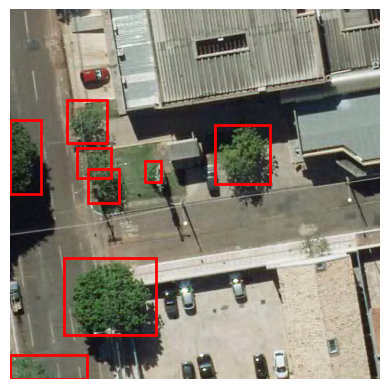

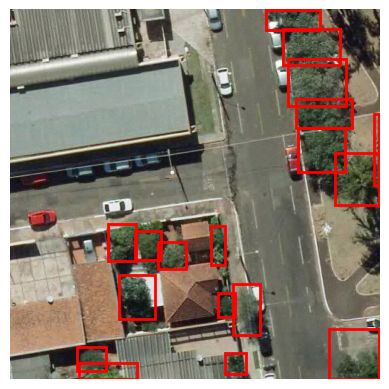

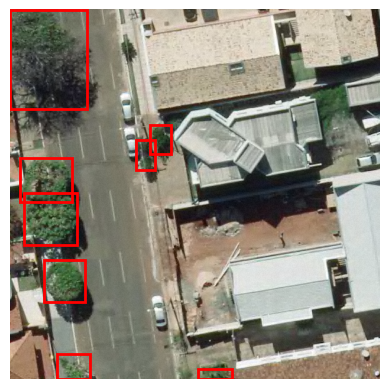

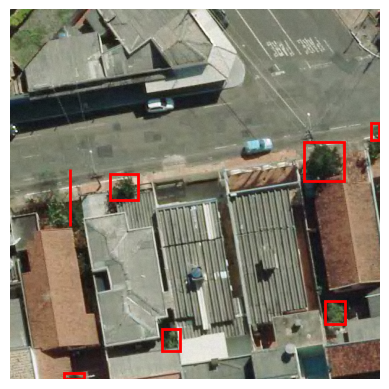

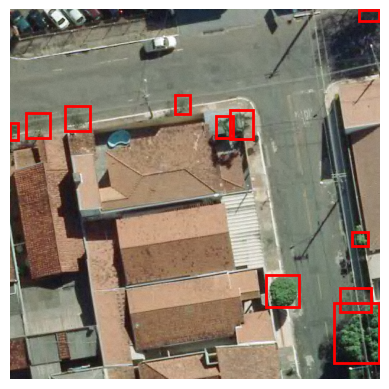

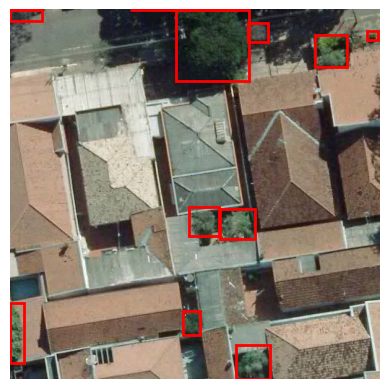

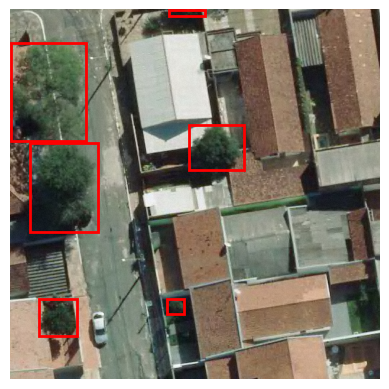

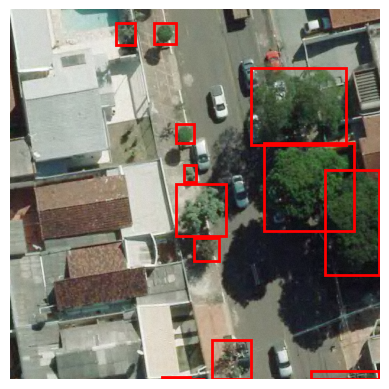

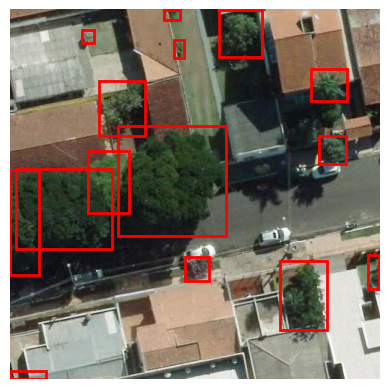

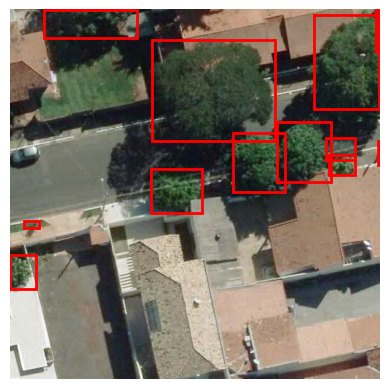

In [ ]:
###############################
##  Visualiza groundtrueth   ##
###############################

# Caminho base dos arquivos
base_path = '/content/RT-DETR/rtdetrv2_pytorch/dataset'

# Caminho das anotações e das imagens
annotations_path = os.path.join(base_path, 'annotations/instances_train.json')
image_dir = os.path.join(base_path, 'imagens/train')

# Carregar o arquivo JSON
with open(annotations_path, 'r') as f:
    data = json.load(f)

# Criar um dicionário para mapear IDs de imagens aos seus nomes
image_id_to_filename = {image['id']: image['file_name'] for image in data['images']}

# Criar um dicionário para agrupar bounding boxes por ID de imagem
image_id_to_bboxes = {}
for annotation in data['annotations']:
    image_id = annotation['image_id']
    bbox = annotation['bbox']  # Bounding box [x, y, width, height]
    if image_id not in image_id_to_bboxes:
        image_id_to_bboxes[image_id] = []
    image_id_to_bboxes[image_id].append(bbox)

# Lista para armazenar as imagens processadas
processed_images = []

# Iterar pelas primeiras 10 imagens
for idx, (image_id, bboxes) in enumerate(image_id_to_bboxes.items()):
    if idx >= 10:  # Limitar a 10 imagens
        break

    file_name = image_id_to_filename.get(image_id)
    if not file_name:
        print(f"Imagem com ID {image_id} não encontrada no JSON.")
        continue

    image_path = os.path.join(image_dir, file_name)
    if not os.path.exists(image_path):
        print(f"Arquivo de imagem não encontrado: {image_path}")
        continue

    # Abrir a imagem
    img = Image.open(image_path)

    # Exibir a imagem com todas as bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Adicionar todas as bounding boxes
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Armazenar a imagem e o gráfico para posterior visualização
    processed_images.append({
        'image': img,
        'annotations': bboxes
    })

    # Mostrar o resultado
    plt.axis('off')
    plt.show()

# Agora, processed_images contém as 10 primeiras imagens com as bounding boxes sobrepostas
# Você pode salvar ou visualizar as imagens processadas mais tarde


In [ ]:
import shutil

# Exclui pasta que não serão mais utilizadas
lista_pastas = ('/content/individual_urban_tree_crown_detection','/content/sample_data')
for folder_path in lista_pastas:
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Remove a pasta e todo o seu conteúdo
        print(f"A pasta {folder_path} e todo o seu conteúdo foram excluídos.")
    else:
        print(f"A pasta {folder_path} não existe.")


A pasta /content/individual_urban_tree_crown_detection e todo o seu conteúdo foram excluídos.
A pasta /content/sample_data e todo o seu conteúdo foram excluídos.


### Atualizando configurações do modelo



In [ ]:
#########################################
##      Indica dataset para treino     ##
#########################################

# Caminho do arquivo YAML
file_path = '/content/RT-DETR/rtdetrv2_pytorch/configs/dataset/coco_detection.yml'

# Novo conteúdo para o arquivo
new_content = """
task: detection

evaluator:
  type: CocoEvaluator
  iou_types: ['bbox', ]

num_classes: 2
remap_mscoco_category: False


train_dataloader:
  type: DataLoader
  dataset:
    type: CocoDetection
    img_folder: /content/RT-DETR/rtdetrv2_pytorch/dataset/imagens/train
    ann_file: /content/RT-DETR/rtdetrv2_pytorch/dataset/annotations/instances_train.json

    return_masks: False
    transforms:
      type: Compose
      ops: ~
  shuffle: True
  num_workers: 4
  drop_last: True
  collate_fn:
    type: BatchImageCollateFuncion


val_dataloader:
  type: DataLoader
  dataset:
    type: CocoDetection
    img_folder: /content/RT-DETR/rtdetrv2_pytorch/dataset/imagens/val
    ann_file: /content/RT-DETR/rtdetrv2_pytorch/dataset/annotations/instances_val.json
    return_masks: False
    transforms:
      type: Compose
      ops: ~
  shuffle: False
  num_workers: 4
  drop_last: False
  collate_fn:
    type: BatchImageCollateFuncion
"""

# Sobrescrever o arquivo YAML
with open(file_path, 'w') as f:
    f.write(new_content)

print(f"Conteúdo do arquivo {file_path} foi alterado com sucesso.")


Conteúdo do arquivo /content/RT-DETR/rtdetrv2_pytorch/configs/dataset/coco_detection.yml foi alterado com sucesso.


In [ ]:
#########################################
##            Treina o modelo          ##
#########################################
!python RT-DETR/rtdetrv2_pytorch/tools/train.py\
  -c /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml

2024-12-17 00:56:09.263630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 00:56:09.280311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 00:56:09.301234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 00:56:09.307584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 00:56:09.323167: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
################################################
##             Continuação até 200            ##
################################################
!python RT-DETR/rtdetrv2_pytorch/tools/train.py \
-c /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml \
-r /content/output/rtdetrv2_r18vd_120e_coco/checkpoint0119.pth

2024-12-17 01:27:03.273793: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 01:27:03.291378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 01:27:03.312783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 01:27:03.319339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 01:27:03.334957: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
################################################
##             Continuação até 300            ##
################################################
# !python RT-DETR/rtdetrv2_pytorch/tools/train.py \
# -c /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml \
# -r /content/output/rtdetrv2_r18vd_120e_coco/checkpoint0119.pth

2024-12-17 01:53:15.873054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 01:53:15.890520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 01:53:15.911903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 01:53:15.918360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 01:53:15.933631: I tensorflow/core/platform/cpu_feature_guar

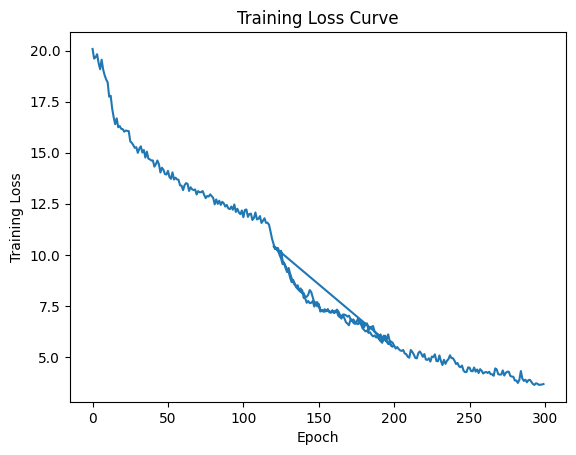

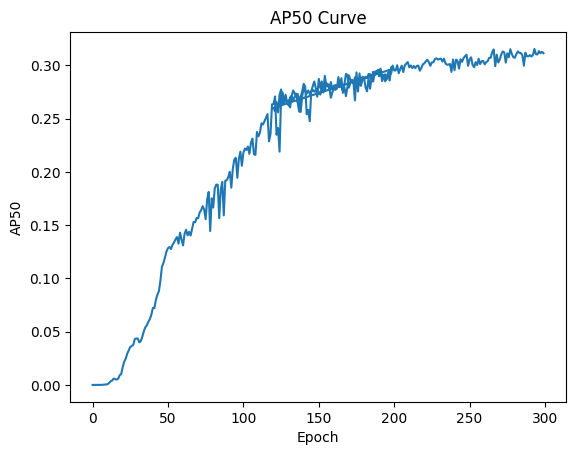

In [ ]:
##########################################
##             Análise do treino        ##
##########################################

# Graficos parte 1

def parse_log_file(file_path):
    epochs = []
    losses = []
    ap50s = []  # Assuming 'test_coco_eval_bbox' is related to AP50

    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            epochs.append(data['epoch'])
            losses.append(data['train_loss'])
            ap50s.append(data['test_coco_eval_bbox'][0])  # Assuming AP50 is the first value

    return epochs, losses, ap50s

# Replace 'log.txt' with the actual path to your log file
epochs, losses, ap50s = parse_log_file('output/rtdetrv2_r18vd_120e_coco/log.txt')

# Plotting the loss curve
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

# Plotting the AP50 curve (if available)
if ap50s:
    plt.plot(epochs, ap50s)
    plt.xlabel('Epoch')
    plt.ylabel('AP50')
    plt.title('AP50 Curve')
    plt.show()

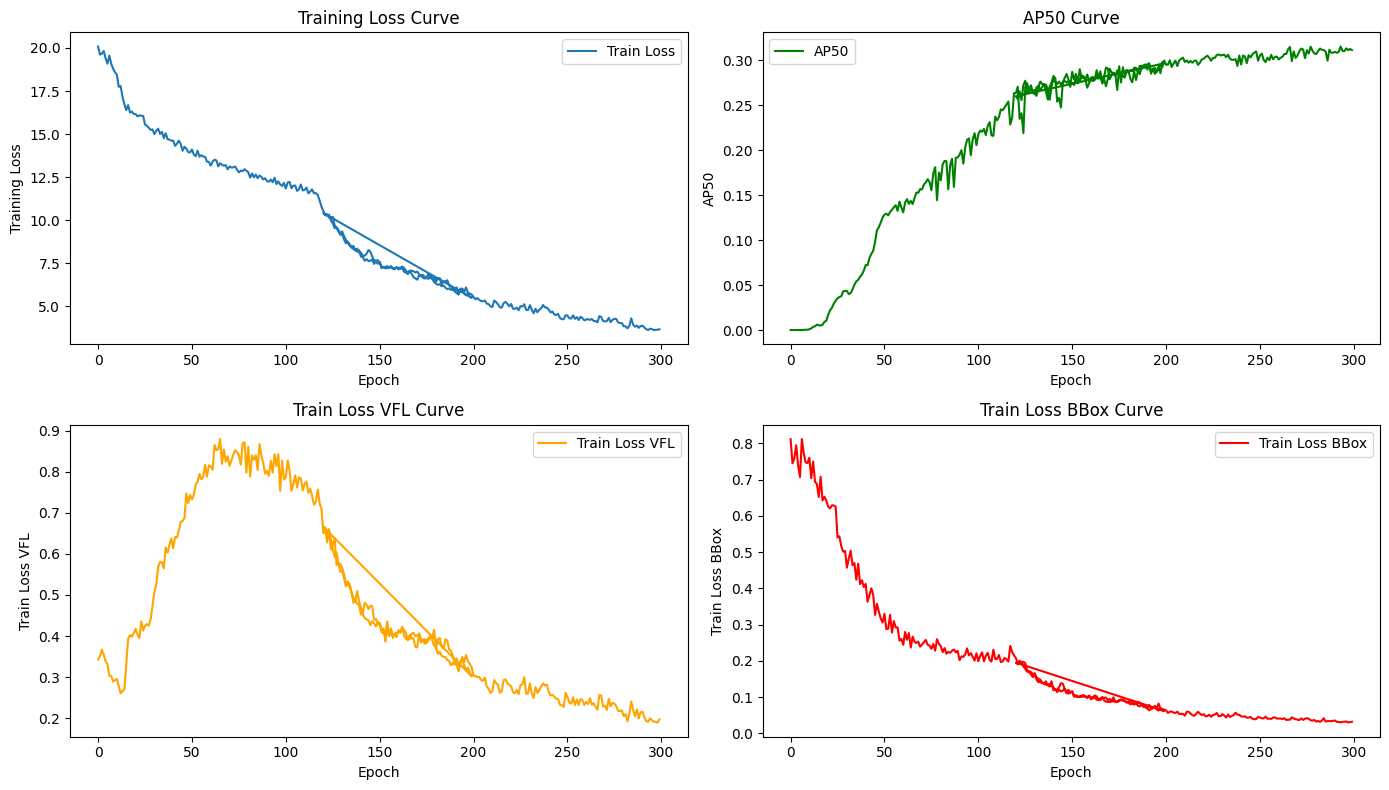

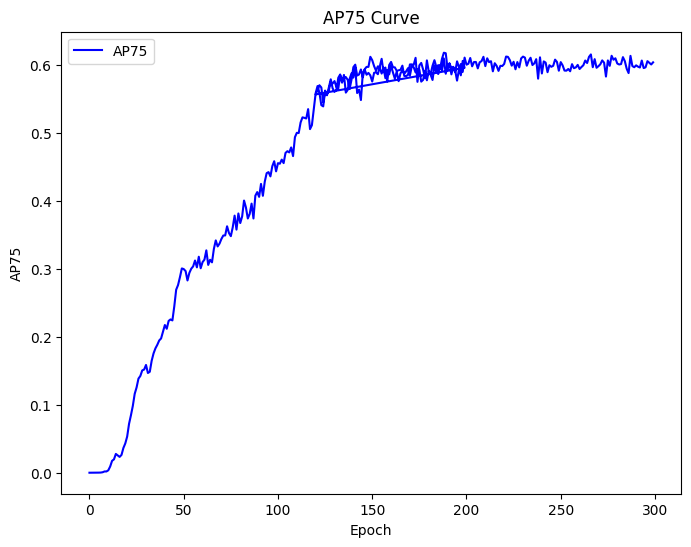

In [ ]:
# Graficos parte 2

def parse_log_file(file_path):
    epochs = []
    losses = []
    ap50s = []  # Assuming 'test_coco_eval_bbox' is related to AP50
    train_loss_vfl = []
    train_loss_bbox = []
    train_loss_giou = []
    ap75s = []  # Assuming 'test_coco_eval_bbox' has multiple values (e.g., AP50, AP75, etc.)

    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            epochs.append(data['epoch'])
            losses.append(data['train_loss'])
            ap50s.append(data['test_coco_eval_bbox'][0])  # AP50
            train_loss_vfl.append(data['train_loss_vfl'])
            train_loss_bbox.append(data['train_loss_bbox'])
            train_loss_giou.append(data['train_loss_giou'])
            if len(data['test_coco_eval_bbox']) > 1:
                ap75s.append(data['test_coco_eval_bbox'][1])  # Assuming AP75 is the second value

    return epochs, losses, ap50s, train_loss_vfl, train_loss_bbox, train_loss_giou, ap75s

# Replace 'log.txt' with the actual path to your log file
epochs, losses, ap50s, train_loss_vfl, train_loss_bbox, train_loss_giou, ap75s = parse_log_file('output/rtdetrv2_r18vd_120e_coco/log.txt')

# Plotting the loss curve
plt.figure(figsize=(14, 8))

# Train Loss Curve
plt.subplot(2, 2, 1)
plt.plot(epochs, losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.legend()

# AP50 Curve
plt.subplot(2, 2, 2)
plt.plot(epochs, ap50s, label='AP50', color='green')
plt.xlabel('Epoch')
plt.ylabel('AP50')
plt.title('AP50 Curve')
plt.legend()

# Training Loss VFL Curve
plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss_vfl, label='Train Loss VFL', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Train Loss VFL')
plt.title('Train Loss VFL Curve')
plt.legend()

# Training Loss BBox Curve
plt.subplot(2, 2, 4)
plt.plot(epochs, train_loss_bbox, label='Train Loss BBox', color='red')
plt.xlabel('Epoch')
plt.ylabel('Train Loss BBox')
plt.title('Train Loss BBox Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Additional plots for AP75 or other metrics
if ap75s:
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, ap75s, label='AP75', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('AP75')
    plt.title('AP75 Curve')
    plt.legend()
    plt.show()


### Copiando código iferencial

In [ ]:
#Cria ferramenta para teste inferencial
file_path = "/content/RT-DETR/rtdetrv2_pytorch/tools/infer.py"
content = """
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.cuda.amp import autocast
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import sys
# sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath(__file__)), '..'))
sys.path.insert(0, '/content/RT-DETR/rtdetrv2_pytorch')
import argparse
# import src.misc.dist as dist
import src.misc.dist_utils as dist
from src.core import YAMLConfig
from src.solver import TASKS
import numpy as np

def postprocess(labels, boxes, scores, iou_threshold=0.55):
    def calculate_iou(box1, box2):
        x1, y1, x2, y2 = box1
        x3, y3, x4, y4 = box2
        xi1 = max(x1, x3)
        yi1 = max(y1, y3)
        xi2 = min(x2, x4)
        yi2 = min(y2, y4)
        inter_width = max(0, xi2 - xi1)
        inter_height = max(0, yi2 - yi1)
        inter_area = inter_width * inter_height
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x4 - x3) * (y4 - y3)
        union_area = box1_area + box2_area - inter_area
        iou = inter_area / union_area if union_area != 0 else 0
        return iou
    merged_labels = []
    merged_boxes = []
    merged_scores = []
    used_indices = set()
    for i in range(len(boxes)):
        if i in used_indices:
            continue
        current_box = boxes[i]
        current_label = labels[i]
        current_score = scores[i]
        boxes_to_merge = [current_box]
        scores_to_merge = [current_score]
        used_indices.add(i)
        for j in range(i + 1, len(boxes)):
            if j in used_indices:
                continue
            if labels[j] != current_label:
                continue
            other_box = boxes[j]
            iou = calculate_iou(current_box, other_box)
            if iou >= iou_threshold:
                boxes_to_merge.append(other_box.tolist())
                scores_to_merge.append(scores[j])
                used_indices.add(j)
        xs = np.concatenate([[box[0], box[2]] for box in boxes_to_merge])
        ys = np.concatenate([[box[1], box[3]] for box in boxes_to_merge])
        merged_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
        merged_score = max(scores_to_merge)
        merged_boxes.append(merged_box)
        merged_labels.append(current_label)
        merged_scores.append(merged_score)
    return [np.array(merged_labels)], [np.array(merged_boxes)], [np.array(merged_scores)]
def slice_image(image, slice_height, slice_width, overlap_ratio):
    img_width, img_height = image.size

    slices = []
    coordinates = []
    step_x = int(slice_width * (1 - overlap_ratio))
    step_y = int(slice_height * (1 - overlap_ratio))

    for y in range(0, img_height, step_y):
        for x in range(0, img_width, step_x):
            box = (x, y, min(x + slice_width, img_width), min(y + slice_height, img_height))
            slice_img = image.crop(box)
            slices.append(slice_img)
            coordinates.append((x, y))
    return slices, coordinates
def merge_predictions(predictions, slice_coordinates, orig_image_size, slice_width, slice_height, threshold=0.30):
    merged_labels = []
    merged_boxes = []
    merged_scores = []
    orig_height, orig_width = orig_image_size
    for i, (label, boxes, scores) in enumerate(predictions):
        x_shift, y_shift = slice_coordinates[i]
        scores = np.array(scores).reshape(-1)
        valid_indices = scores > threshold
        valid_labels = np.array(label).reshape(-1)[valid_indices]
        valid_boxes = np.array(boxes).reshape(-1, 4)[valid_indices]
        valid_scores = scores[valid_indices]
        for j, box in enumerate(valid_boxes):
            box[0] = np.clip(box[0] + x_shift, 0, orig_width)
            box[1] = np.clip(box[1] + y_shift, 0, orig_height)
            box[2] = np.clip(box[2] + x_shift, 0, orig_width)
            box[3] = np.clip(box[3] + y_shift, 0, orig_height)
            valid_boxes[j] = box
        merged_labels.extend(valid_labels)
        merged_boxes.extend(valid_boxes)
        merged_scores.extend(valid_scores)
    return np.array(merged_labels), np.array(merged_boxes), np.array(merged_scores)
def draw(images, labels, boxes, scores, thrh = 0.6, path = "", line_width=3, font_size=24):
    for i, im in enumerate(images):
        draw = ImageDraw.Draw(im)
        scr = scores[i]
        lab = labels[i][scr > thrh]
        box = boxes[i][scr > thrh]
        scrs = scores[i][scr > thrh]
        for j,b in enumerate(box):
            draw.rectangle(list(b), outline='green', width=line_width)
            draw.text((b[0], b[1]), text=f"label: {lab[j].item()} {round(scrs[j].item(),2)}", font=ImageFont.load_default(), fill='yellow')
        if path == "":
            im.save(f'results_{i}.jpg')
        else:
            im.save(path)

def main(args, ):
    \"\"\"main
    \"\"\"
    cfg = YAMLConfig(args.config, resume=args.resume)
    if args.resume:
        checkpoint = torch.load(args.resume, map_location='cpu')
        if 'ema' in checkpoint:
            state = checkpoint['ema']['module']
        else:
            state = checkpoint['model']
    else:
        raise AttributeError('Only support resume to load model.state_dict by now.')
    cfg.model.load_state_dict(state)
    class Model(nn.Module):
        def __init__(self, ) -> None:
            super().__init__()
            self.model = cfg.model.deploy()
            self.postprocessor = cfg.postprocessor.deploy()

        def forward(self, images, orig_target_sizes):
            outputs = self.model(images)
            outputs = self.postprocessor(outputs, orig_target_sizes)
            return outputs

    model = Model().to(args.device)
    im_pil = Image.open(args.im_file).convert('RGB')
    w, h = im_pil.size
    orig_size = torch.tensor([w, h])[None].to(args.device)

    transforms = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
    ])
    im_data = transforms(im_pil)[None].to(args.device)
    if args.sliced:
        num_boxes = args.numberofboxes

        aspect_ratio = w / h
        num_cols = int(np.sqrt(num_boxes * aspect_ratio))
        num_rows = int(num_boxes / num_cols)
        slice_height = h // num_rows
        slice_width = w // num_cols
        overlap_ratio = 0.2
        slices, coordinates = slice_image(im_pil, slice_height, slice_width, overlap_ratio)
        predictions = []
        for i, slice_img in enumerate(slices):
            slice_tensor = transforms(slice_img)[None].to(args.device)
            with autocast():
                output = model(slice_tensor, torch.tensor([[slice_img.size[0], slice_img.size[1]]]).to(args.device))
            torch.cuda.empty_cache()
            labels, boxes, scores = output

            labels = labels.cpu().detach().numpy()
            boxes = boxes.cpu().detach().numpy()
            scores = scores.cpu().detach().numpy()
            predictions.append((labels, boxes, scores))

        merged_labels, merged_boxes, merged_scores = merge_predictions(predictions, coordinates, (h, w), slice_width, slice_height)
        labels, boxes, scores = postprocess(merged_labels, merged_boxes, merged_scores)
    else:
        output = model(im_data, orig_size)
        labels, boxes, scores = output

    draw([im_pil], labels, boxes, scores, 0.6)

if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-c', '--config', type=str, )
    parser.add_argument('-r', '--resume', type=str, )
    parser.add_argument('-f', '--im-file', type=str, )
    parser.add_argument('-s', '--sliced', type=bool, default=False)
    parser.add_argument('-d', '--device', type=str, default='cpu')
    parser.add_argument('-nc', '--numberofboxes', type=int, default=25)
    args = parser.parse_args()
    main(args)
"""

# Criando o arquivo
with open(file_path, "w") as file:
    file.write(content)

print(f"Arquivo criado: {file_path}")


Arquivo criado: /content/RT-DETR/rtdetrv2_pytorch/tools/infer.py


In [ ]:
###############################################
##                 INFERENCIA                ##
###############################################

!python3 /content/RT-DETR/rtdetrv2_pytorch/tools/infer.py \
    --config /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml \
    --resume /content/output/rtdetrv2_r18vd_120e_coco/best.pth \
    --im-file /content/RT-DETR/rtdetrv2_pytorch/dataset/imagens/val/72.png \
    --device cuda

2024-12-17 02:46:15.619464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 02:46:15.636530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 02:46:15.657964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 02:46:15.664381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 02:46:15.679673: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
###############################################
##                 INFERENCIA                ##
###############################################

!python3 /content/RT-DETR/rtdetrv2_pytorch/tools/infer.py \
    --config /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml \
    --resume /content/output/rtdetrv2_r18vd_120e_coco/checkpoint0153.pth \
    --im-file /content/RT-DETR/rtdetrv2_pytorch/dataset/imagens/test/84.png

2024-12-17 02:47:47.975265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 02:47:47.993105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 02:47:48.014351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 02:47:48.020829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 02:47:48.035882: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
############################################
##            Transfere + teste           ##
############################################

!python3 /content/RT-DETR/rtdetrv2_pytorch/tools/train.py \
  -c /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml\
  -r /content/output/rtdetrv2_r18vd_120e_coco/checkpoint0120.pth\
  --test-only

2024-12-17 02:30:45.143646: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 02:30:45.160957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 02:30:45.182622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 02:30:45.189062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 02:30:45.204133: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
############################################
##            Transfere + teste + log     ##
############################################

# !python3 /content/RT-DETR/rtdetrv2_pytorch/tools/train.py \
#   -c /content/RT-DETR/rtdetrv2_pytorch/configs/rtdetrv2/rtdetrv2_r18vd_120e_coco.yml\
#   -r /content/output/rtdetrv2_r18vd_120e_coco/best.pth\
#   --test-only\
#   --output-dir /content/Test

2024-12-17 01:50:29.497360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 01:50:29.515352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 01:50:29.536628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 01:50:29.543061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 01:50:29.558795: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import pandas as pd
import json

def read_log_file(log_path):
    """Lê o arquivo de log e retorna uma lista de dicionários."""
    data = []
    with open(log_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                try:
                    record = json.loads(line)
                    data.append(record)
                except json.JSONDecodeError as e:
                    print(f"Erro ao decodificar JSON: {e}")
    return data

def round_numeric_columns(df, decimal_places=6):
    """Arredonda as colunas numéricas do DataFrame."""
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].round(decimal_places)
    return df

# Caminho do arquivo de log
log_path = '/content/output/rtdetrv2_r18vd_120e_coco/log.txt'

# Lê o arquivo de log e cria um DataFrame
data = read_log_file(log_path)
df = pd.DataFrame(data)

# Arredonda as colunas numéricas
df_rounded = round_numeric_columns(df)

# Salva o DataFrame como CSV
df_rounded.to_csv('/content/log_epocas.csv', index=True, sep=';', decimal=',')